# 2. Visualizing with SOM

Import required modules

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from minisom import MiniSom

In [55]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.to_numpy().astype(float) / 255.0
y = mnist.target.astype(int)

print("Original shape:", X.shape)
print("Unique digits:", np.unique(y))

Original shape: (70000, 784)
Unique digits: [0 1 2 3 4 5 6 7 8 9]


In [56]:
X_small, _, y_small, _ = train_test_split(
    X, y, train_size=10000, stratify=y, random_state=42
)
y_small = np.array(y_small)

print("Subset shape:", X_small.shape)
print("Digit distribution:\n", pd.Series(y_small).value_counts().sort_index())

Subset shape: (10000, 784)
Digit distribution:
 0     986
1    1125
2     999
3    1020
4     975
5     902
6     982
7    1042
8     975
9     994
Name: count, dtype: int64


# Observations

The MNIST-784 dataset comprises 70,000 grayscale images of handwritten digits from 0 to 9.
each represented by 784 pixel values (28×28).
A balanced subset with 10,000 samples was used for faster training while maintaining
Class representation across all digits.
Normalization to the interval [0,1] ensures numerical stability and better convergence of the Self-Organizing Map.

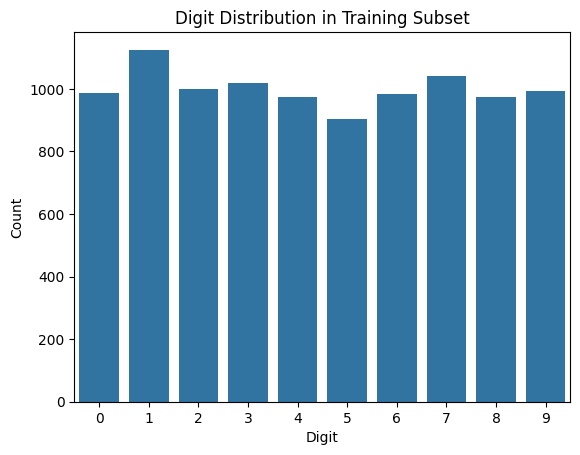

In [57]:
sns.countplot(x=y_small)
plt.title("Digit Distribution in Training Subset")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

In [ ]:
som_x, som_y = 20, 20
som = MiniSom(
    x=som_x, y=som_y, input_len=X_small.shape[1],
    sigma=1.0, learning_rate=0.3, random_seed=42
)

som.random_weights_init(X_small)
print("Training SOM... (~1-2 minutes)")
som.train_random(X_small, num_iteration=25000, verbose=True)
print("SOM training complete.")

Training SOM... (~1-2 minutes)
 [ 25000 / 25000 ] 100% - 0:00:00 left 
 quantization error: 4.691513749377328
SOM training complete.


# Observations

The SOM was trained by using a 20×20 neuron grid and a decreasing learning rate.
and neighborhood radius. In more than 25,000 iterations, the SOM learned to represent
high-dimensional digit images in a two-dimensional grid where similar digits
are mapped to nearby neurons.
This competitive learning process reflects the principle described in Lecture 8e -
The neurons compete to represent patterns, forming a topological structure.

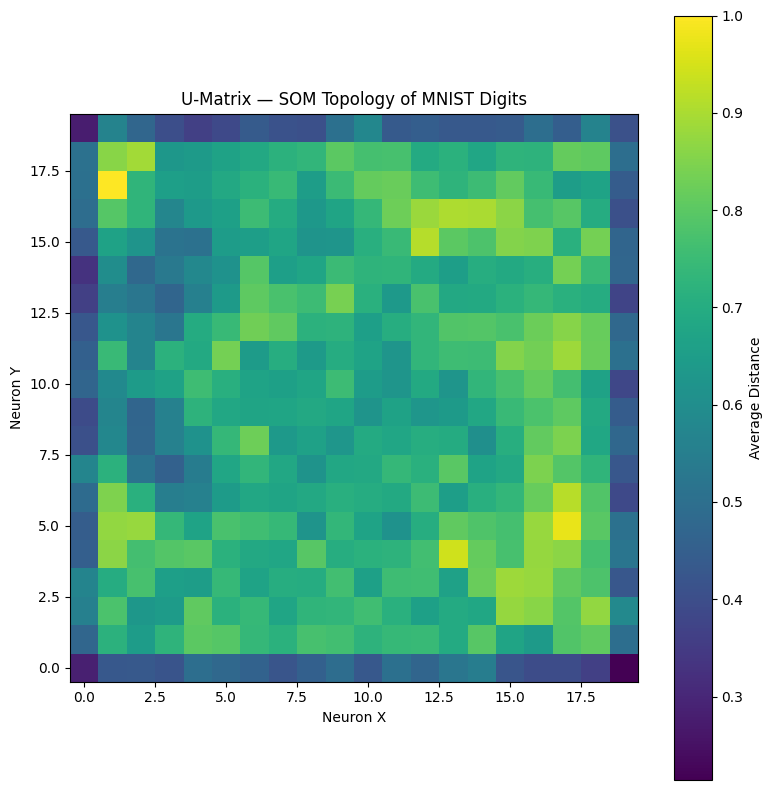

In [59]:
plt.figure(figsize=(8,8))
u_matrix = som.distance_map().T
plt.imshow(u_matrix, cmap="viridis", origin="lower")
plt.title("U-Matrix — SOM Topology of MNIST Digits")
plt.xlabel("Neuron X")
plt.ylabel("Neuron Y")
plt.colorbar(label="Average Distance")
plt.tight_layout()
plt.show()

# Observations

The U-Matrix shows distances between neighboring neurons.
Brighter regions correspond to a high dissimilarity and indicate cluster boundaries between different digit groups.
Darker regions are areas of high similarity where the neurons represent similar digits.
This indicates that the SOM has learned some meaningful underlying structural relationships in the handwritten digits data.

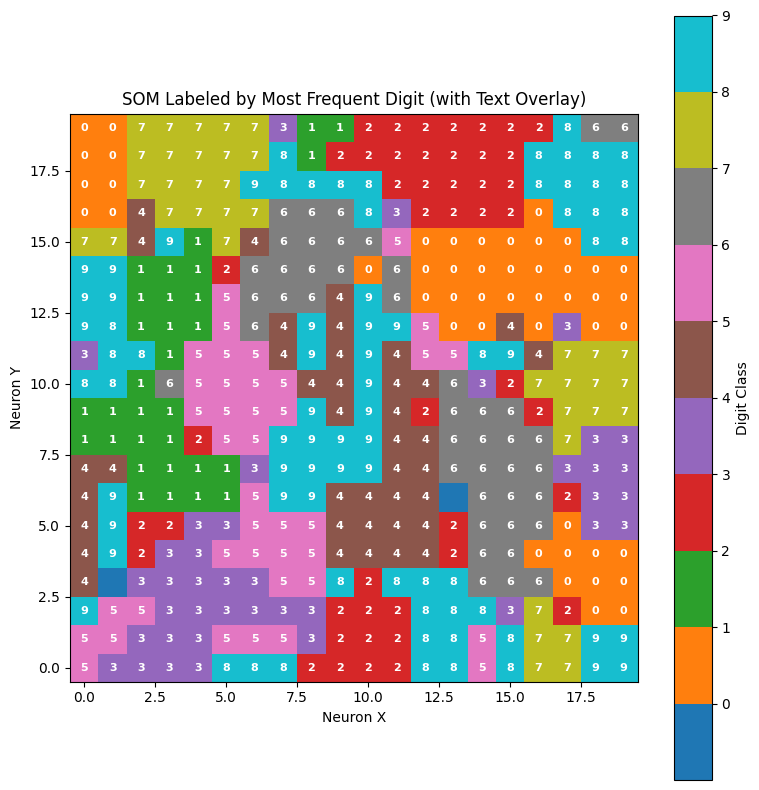

In [ ]:
win_map = som.win_map(X_small)

label_grid = np.full((som_x, som_y), -1, dtype=int)
for i in range(som_x):
    for j in range(som_y):
        samples = win_map.get((i, j), [])
        if len(samples) > 0:
            
            label_indices = [np.where((X_small == s).all(axis=1))[0][0] for s in samples]
            mapped_labels = y_small[label_indices]
            label_grid[i, j] = np.bincount(mapped_labels).argmax()


plt.figure(figsize=(8,8))
plt.imshow(label_grid.T, cmap="tab10", origin="lower")
plt.title("SOM Labeled by Most Frequent Digit (with Text Overlay)")
plt.xlabel("Neuron X")
plt.ylabel("Neuron Y")
cbar = plt.colorbar(ticks=range(10))
cbar.set_label("Digit Class")

for i in range(som_x):
    for j in range(som_y):
        label = label_grid[i, j]
        if label >= 0:
            plt.text(i, j, str(label), ha="center", va="center", color="white",
                     fontsize=8, fontweight="bold")

plt.tight_layout()
plt.show()

# Observations

Indeed, the SOM tagged map indicates that similar digits are found occupying neighboring regions.
(e.g., 3 and 8, or 4 and 9), showing that the SOM preserves
topological proximity between visually similar patterns.
Color-coded regions correspond to dominant digit clusters, while small
Mixed regions indicate overlapping digit shapes or ambiguous handwriting.
This demonstrates SOM's capabilities in non-linear dimensionality reduction.
and organize the high-dimensional input data into a two-dimensional structure.

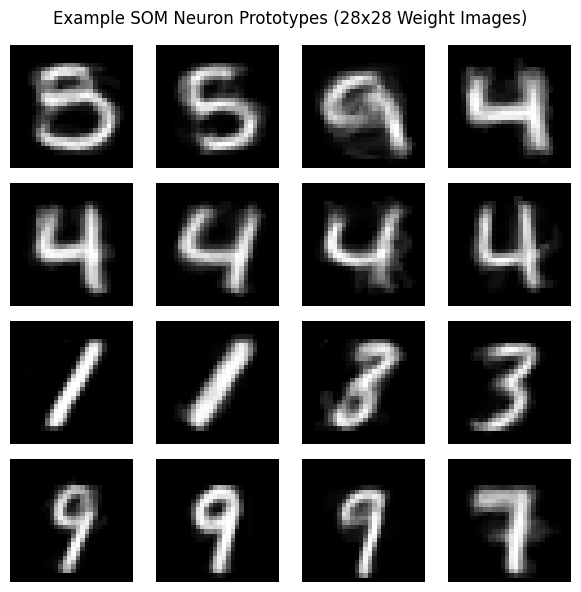

In [61]:
weights = som.get_weights()
fig, axes = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    wx, wy = divmod(i, som_y)
    ax.imshow(weights[wx, wy].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Example SOM Neuron Prototypes (28x28 Weight Images)")
plt.tight_layout()
plt.show()

# Observations

Every neuron weight vector can be thought of as a prototype image.
These prototypes represent the general form of the digits learned by the SOM.
Smooth transitions between neighboring prototypes demonstrate that
similar digits are represented close to each other, confirming
that the SOM successfully learned a topological ordering.

# Summary

The Self-Organizing Map provides a powerful nonlinear visualization method for high-dimensional data.
In this experiment, the SOM was able to project 784-dimensional MNIST digits onto a 2D grid successfully.
while preserving the relative relationships of digit classes.
Compared to PCA and t-SNE, SOM offers an interpretable grid structure and prototype visualization.
However, as noted in Lecture 8e, this is a heuristic method and in no way guarantees an optimal
local structure preservation.
Overall, the SOM visualization brings to light meaningful clusters of handwritten digits and demonstrates
the model's capability of unsupervised feature organization.